In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

In [2]:
from util import getHash

name = 'FNN-Classification-Simple'

props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    #'radiomics'     : ['b10','b25','b50','b75'],
    #'radiomics_vox' : ['k5_b25','k7_b25','k9_b25','k11_b25'],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'targets_all'   : False,
    'collapse_max'  : False,
    'debug'         : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_CCE_7_1_1_0_1_0_e_e_0_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_0_05_06


In [3]:
from DataGeneratorClassificationFNN import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4339345, 828)
(4339345, 8)
validation
(669326, 828)
(669326, 8)
test
(492897, 828)
(492897, 8)


In [4]:
from ModelClassificationFNN import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/'+props['space']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 2048)              1697792   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 8)                 1032      


Total params: 4486024 (17.11 MB)


Trainable params: 4486024 (17.11 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

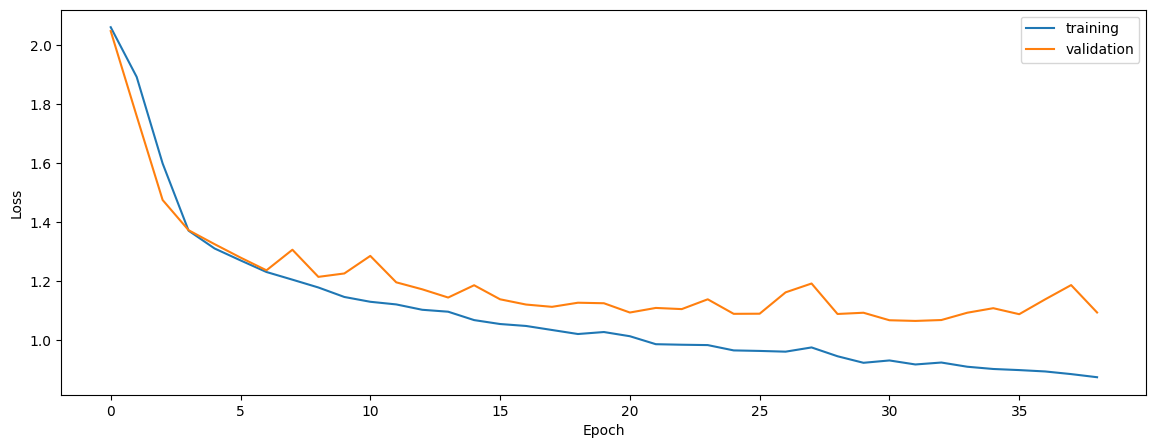

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [7]:
props1 = props
model1 = model

In [8]:
props = props.copy()
props['binarize'] = False
props['not_connected'] = False
props['collapse_max'] = True

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 100000,
    'patience'      : 7,
}

HASH = getHash(name,[architecture,props])
print(HASH)

FNN-Classification-Simple-sigmoid_100000_2048_1024_512_256_128_0001_MSE_7_1_0_1_1_0_e_e_0_0_0_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_native_08_0_05_06


In [9]:
gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1160792, 828)
(1160792, 1)
validation
(184723, 828)
(184723, 1)
test
(137164, 828)
(137164, 1)


In [10]:
stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASH),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_2 (InputLayer)        [(None, 828)]             0         


 dense_6 (Dense)             (None, 2048)              1697792   


 dense_7 (Dense)             (None, 1024)              2098176   


 dense_8 (Dense)             (None, 512)               524800    


 dense_9 (Dense)             (None, 256)               131328    


 dense_10 (Dense)            (None, 128)               32896     


 dense_11 (Dense)            (None, 1)                 129       


Total params: 4485121 (17.11 MB)


Trainable params: 4485121 (17.11 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [11]:
if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASH)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASH), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASH))

Epoch 1/10000


 1/12 [=>............................] - ETA: 1:32 - loss: 0.2189 - STD: 3.0246e-05 - MAE: 0.4487

 2/12 [====>.........................] - ETA: 1:31 - loss: 0.2338 - STD: 1.0871e-04 - MAE: 0.4357

 3/12 [======>.......................] - ETA: 43s - loss: 0.2281 - STD: 1.9252e-04 - MAE: 0.4406 

 4/12 [=========>....................] - ETA: 26s - loss: 0.2303 - STD: 2.4774e-04 - MAE: 0.4495

 5/12 [===========>..................] - ETA: 18s - loss: 0.2297 - STD: 2.9718e-04 - MAE: 0.4532

 6/12 [==============>...............] - ETA: 13s - loss: 0.2279 - STD: 3.4286e-04 - MAE: 0.4528

 7/12 [================>.............] - ETA: 9s - loss: 0.2270 - STD: 3.7798e-04 - MAE: 0.4504 

 8/12 [===================>..........] - ETA: 6s - loss: 0.2269 - STD: 4.0453e-04 - MAE: 0.4481

 9/12 [=====================>........] - ETA: 4s - loss: 0.2267 - STD: 4.2775e-04 - MAE: 0.4464

10/12 [========================>.....] - ETA: 2s - loss: 0.2261 - STD: 4.4968e-04 - MAE: 0.4454

11/12 [==========================>...] - ETA: 1s - loss: 0.2254 - STD: 4.6937e-04 - MAE: 0.4454

12/12 [==============================] - ETA: 0s - loss: 0.2250 - STD: 4.8623e-04 - MAE: 0.4461

12/12 [==============================] - 27s 2s/step - loss: 0.2250 - STD: 4.8623e-04 - MAE: 0.4461 - val_loss: 0.2230 - val_STD: 6.6044e-04 - val_MAE: 0.4611


Epoch 2/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.2218 - STD: 6.7506e-04 - MAE: 0.4593

 2/12 [====>.........................] - ETA: 6s - loss: 0.2220 - STD: 6.7926e-04 - MAE: 0.4599 

 3/12 [======>.......................] - ETA: 5s - loss: 0.2217 - STD: 6.8672e-04 - MAE: 0.4591

 4/12 [=========>....................] - ETA: 4s - loss: 0.2211 - STD: 6.9745e-04 - MAE: 0.4575

 5/12 [===========>..................] - ETA: 3s - loss: 0.2206 - STD: 7.0727e-04 - MAE: 0.4554

 6/12 [==============>...............] - ETA: 2s - loss: 0.2205 - STD: 7.1849e-04 - MAE: 0.4532

 7/12 [================>.............] - ETA: 2s - loss: 0.2206 - STD: 7.3038e-04 - MAE: 0.4513

 8/12 [===================>..........] - ETA: 1s - loss: 0.2206 - STD: 7.4433e-04 - MAE: 0.4497

 9/12 [=====================>........] - ETA: 1s - loss: 0.2205 - STD: 7.6130e-04 - MAE: 0.4486

10/12 [========================>.....] - ETA: 0s - loss: 0.2203 - STD: 7.8135e-04 - MAE: 0.4480

11/12 [==========================>...] - ETA: 0s - loss: 0.2202 - STD: 8.0409e-04 - MAE: 0.4479

12/12 [==============================] - ETA: 0s - loss: 0.2201 - STD: 8.2986e-04 - MAE: 0.4482

12/12 [==============================] - 8s 604ms/step - loss: 0.2201 - STD: 8.2986e-04 - MAE: 0.4482 - val_loss: 0.2198 - val_STD: 0.0012 - val_MAE: 0.4545


Epoch 3/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.2195 - STD: 0.0012 - MAE: 0.4536

 2/12 [====>.........................] - ETA: 4s - loss: 0.2194 - STD: 0.0013 - MAE: 0.4536 

 3/12 [======>.......................] - ETA: 4s - loss: 0.2193 - STD: 0.0013 - MAE: 0.4533

 4/12 [=========>....................] - ETA: 3s - loss: 0.2192 - STD: 0.0014 - MAE: 0.4526

 5/12 [===========>..................] - ETA: 2s - loss: 0.2192 - STD: 0.0014 - MAE: 0.4516

 6/12 [==============>...............] - ETA: 2s - loss: 0.2190 - STD: 0.0015 - MAE: 0.4504

 7/12 [================>.............] - ETA: 2s - loss: 0.2190 - STD: 0.0016 - MAE: 0.4493

 8/12 [===================>..........] - ETA: 1s - loss: 0.2190 - STD: 0.0017 - MAE: 0.4484

 9/12 [=====================>........] - ETA: 1s - loss: 0.2190 - STD: 0.0018 - MAE: 0.4479

10/12 [========================>.....] - ETA: 0s - loss: 0.2190 - STD: 0.0019 - MAE: 0.4476

11/12 [==========================>...] - ETA: 0s - loss: 0.2189 - STD: 0.0021 - MAE: 0.4475

12/12 [==============================] - ETA: 0s - loss: 0.2189 - STD: 0.0022 - MAE: 0.4476

12/12 [==============================] - 8s 613ms/step - loss: 0.2189 - STD: 0.0022 - MAE: 0.4476 - val_loss: 0.2182 - val_STD: 0.0043 - val_MAE: 0.4510


Epoch 4/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.2184 - STD: 0.0044 - MAE: 0.4506

 2/12 [====>.........................] - ETA: 4s - loss: 0.2182 - STD: 0.0048 - MAE: 0.4504 

 3/12 [======>.......................] - ETA: 4s - loss: 0.2181 - STD: 0.0052 - MAE: 0.4500

 4/12 [=========>....................] - ETA: 3s - loss: 0.2180 - STD: 0.0056 - MAE: 0.4493

 5/12 [===========>..................] - ETA: 3s - loss: 0.2178 - STD: 0.0061 - MAE: 0.4483

 6/12 [==============>...............] - ETA: 3s - loss: 0.2176 - STD: 0.0066 - MAE: 0.4473

 7/12 [================>.............] - ETA: 2s - loss: 0.2174 - STD: 0.0073 - MAE: 0.4464

 8/12 [===================>..........] - ETA: 2s - loss: 0.2172 - STD: 0.0080 - MAE: 0.4457

 9/12 [=====================>........] - ETA: 1s - loss: 0.2169 - STD: 0.0089 - MAE: 0.4452

10/12 [========================>.....] - ETA: 0s - loss: 0.2168 - STD: 0.0100 - MAE: 0.4448

11/12 [==========================>...] - ETA: 0s - loss: 0.2165 - STD: 0.0113 - MAE: 0.4445

12/12 [==============================] - ETA: 0s - loss: 0.2161 - STD: 0.0128 - MAE: 0.4442

12/12 [==============================] - 8s 600ms/step - loss: 0.2161 - STD: 0.0128 - MAE: 0.4442 - val_loss: 0.2099 - val_STD: 0.0350 - val_MAE: 0.4380


Epoch 5/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.2110 - STD: 0.0353 - MAE: 0.4379

 2/12 [====>.........................] - ETA: 4s - loss: 0.2101 - STD: 0.0385 - MAE: 0.4357 

 3/12 [======>.......................] - ETA: 3s - loss: 0.2096 - STD: 0.0419 - MAE: 0.4335

 4/12 [=========>....................] - ETA: 3s - loss: 0.2085 - STD: 0.0459 - MAE: 0.4315

 5/12 [===========>..................] - ETA: 3s - loss: 0.2075 - STD: 0.0507 - MAE: 0.4298

 6/12 [==============>...............] - ETA: 2s - loss: 0.2066 - STD: 0.0560 - MAE: 0.4282

 7/12 [================>.............] - ETA: 2s - loss: 0.2057 - STD: 0.0617 - MAE: 0.4265

 8/12 [===================>..........] - ETA: 1s - loss: 0.2049 - STD: 0.0671 - MAE: 0.4247

 9/12 [=====================>........] - ETA: 1s - loss: 0.2040 - STD: 0.0720 - MAE: 0.4227

10/12 [========================>.....] - ETA: 0s - loss: 0.2033 - STD: 0.0765 - MAE: 0.4210

11/12 [==========================>...] - ETA: 0s - loss: 0.2026 - STD: 0.0810 - MAE: 0.4194

12/12 [==============================] - ETA: 0s - loss: 0.2020 - STD: 0.0854 - MAE: 0.4181

12/12 [==============================] - 8s 616ms/step - loss: 0.2020 - STD: 0.0854 - MAE: 0.4181 - val_loss: 0.1917 - val_STD: 0.1385 - val_MAE: 0.3997


Epoch 6/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.1950 - STD: 0.1395 - MAE: 0.4018

 2/12 [====>.........................] - ETA: 3s - loss: 0.1950 - STD: 0.1391 - MAE: 0.4016 

 3/12 [======>.......................] - ETA: 3s - loss: 0.1948 - STD: 0.1390 - MAE: 0.4011

 4/12 [=========>....................] - ETA: 3s - loss: 0.1945 - STD: 0.1401 - MAE: 0.4004

 5/12 [===========>..................] - ETA: 3s - loss: 0.1942 - STD: 0.1425 - MAE: 0.3994

 6/12 [==============>...............] - ETA: 2s - loss: 0.1941 - STD: 0.1450 - MAE: 0.3985

 7/12 [================>.............] - ETA: 2s - loss: 0.1940 - STD: 0.1467 - MAE: 0.3977

 8/12 [===================>..........] - ETA: 2s - loss: 0.1939 - STD: 0.1477 - MAE: 0.3970

 9/12 [=====================>........] - ETA: 1s - loss: 0.1938 - STD: 0.1490 - MAE: 0.3965

10/12 [========================>.....] - ETA: 1s - loss: 0.1936 - STD: 0.1504 - MAE: 0.3959

11/12 [==========================>...] - ETA: 0s - loss: 0.1935 - STD: 0.1515 - MAE: 0.3956

12/12 [==============================] - ETA: 0s - loss: 0.1932 - STD: 0.1518 - MAE: 0.3953

12/12 [==============================] - 8s 616ms/step - loss: 0.1932 - STD: 0.1518 - MAE: 0.3953 - val_loss: 0.1903 - val_STD: 0.1553 - val_MAE: 0.3917


Epoch 7/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1913 - STD: 0.1591 - MAE: 0.3910

 2/12 [====>.........................] - ETA: 4s - loss: 0.1909 - STD: 0.1631 - MAE: 0.3895 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1911 - STD: 0.1645 - MAE: 0.3890

 4/12 [=========>....................] - ETA: 3s - loss: 0.1911 - STD: 0.1634 - MAE: 0.3887

 5/12 [===========>..................] - ETA: 3s - loss: 0.1910 - STD: 0.1638 - MAE: 0.3886

 6/12 [==============>...............] - ETA: 2s - loss: 0.1909 - STD: 0.1644 - MAE: 0.3886

 7/12 [================>.............] - ETA: 2s - loss: 0.1909 - STD: 0.1636 - MAE: 0.3887

 8/12 [===================>..........] - ETA: 1s - loss: 0.1909 - STD: 0.1625 - MAE: 0.3890

 9/12 [=====================>........] - ETA: 1s - loss: 0.1909 - STD: 0.1623 - MAE: 0.3892

10/12 [========================>.....] - ETA: 0s - loss: 0.1909 - STD: 0.1626 - MAE: 0.3893

11/12 [==========================>...] - ETA: 0s - loss: 0.1909 - STD: 0.1623 - MAE: 0.3893

12/12 [==============================] - ETA: 0s - loss: 0.1908 - STD: 0.1619 - MAE: 0.3892

12/12 [==============================] - 8s 630ms/step - loss: 0.1908 - STD: 0.1619 - MAE: 0.3892 - val_loss: 0.1893 - val_STD: 0.1675 - val_MAE: 0.3875


Epoch 8/10000


 1/12 [=>............................] - ETA: 12s - loss: 0.1888 - STD: 0.1696 - MAE: 0.3857

 2/12 [====>.........................] - ETA: 5s - loss: 0.1893 - STD: 0.1687 - MAE: 0.3861 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1893 - STD: 0.1654 - MAE: 0.3861

 4/12 [=========>....................] - ETA: 4s - loss: 0.1893 - STD: 0.1651 - MAE: 0.3862

 5/12 [===========>..................] - ETA: 3s - loss: 0.1893 - STD: 0.1663 - MAE: 0.3863

 6/12 [==============>...............] - ETA: 3s - loss: 0.1895 - STD: 0.1655 - MAE: 0.3868

 7/12 [================>.............] - ETA: 2s - loss: 0.1894 - STD: 0.1646 - MAE: 0.3869

 8/12 [===================>..........] - ETA: 1s - loss: 0.1894 - STD: 0.1655 - MAE: 0.3868

 9/12 [=====================>........] - ETA: 1s - loss: 0.1893 - STD: 0.1654 - MAE: 0.3867

10/12 [========================>.....] - ETA: 1s - loss: 0.1891 - STD: 0.1653 - MAE: 0.3865

11/12 [==========================>...] - ETA: 0s - loss: 0.1891 - STD: 0.1659 - MAE: 0.3863

12/12 [==============================] - ETA: 0s - loss: 0.1890 - STD: 0.1663 - MAE: 0.3861

12/12 [==============================] - 8s 618ms/step - loss: 0.1890 - STD: 0.1663 - MAE: 0.3861 - val_loss: 0.1880 - val_STD: 0.1707 - val_MAE: 0.3844


Epoch 9/10000


 1/12 [=>............................] - ETA: 6s - loss: 0.1884 - STD: 0.1656 - MAE: 0.3849

 2/12 [====>.........................] - ETA: 6s - loss: 0.1874 - STD: 0.1683 - MAE: 0.3839

 3/12 [======>.......................] - ETA: 5s - loss: 0.1875 - STD: 0.1685 - MAE: 0.3839

 4/12 [=========>....................] - ETA: 4s - loss: 0.1874 - STD: 0.1681 - MAE: 0.3838

 5/12 [===========>..................] - ETA: 3s - loss: 0.1875 - STD: 0.1690 - MAE: 0.3837

 6/12 [==============>...............] - ETA: 3s - loss: 0.1875 - STD: 0.1692 - MAE: 0.3836

 7/12 [================>.............] - ETA: 2s - loss: 0.1876 - STD: 0.1686 - MAE: 0.3837

 8/12 [===================>..........] - ETA: 2s - loss: 0.1876 - STD: 0.1697 - MAE: 0.3836

 9/12 [=====================>........] - ETA: 1s - loss: 0.1876 - STD: 0.1695 - MAE: 0.3836

10/12 [========================>.....] - ETA: 1s - loss: 0.1875 - STD: 0.1692 - MAE: 0.3836

11/12 [==========================>...] - ETA: 0s - loss: 0.1875 - STD: 0.1697 - MAE: 0.3836

12/12 [==============================] - ETA: 0s - loss: 0.1875 - STD: 0.1693 - MAE: 0.3835

12/12 [==============================] - 8s 644ms/step - loss: 0.1875 - STD: 0.1693 - MAE: 0.3835 - val_loss: 0.1880 - val_STD: 0.1809 - val_MAE: 0.3822


Epoch 10/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.1870 - STD: 0.1754 - MAE: 0.3818

 2/12 [====>.........................] - ETA: 5s - loss: 0.1871 - STD: 0.1747 - MAE: 0.3821

 3/12 [======>.......................] - ETA: 5s - loss: 0.1868 - STD: 0.1716 - MAE: 0.3820

 4/12 [=========>....................] - ETA: 4s - loss: 0.1866 - STD: 0.1735 - MAE: 0.3816

 5/12 [===========>..................] - ETA: 3s - loss: 0.1865 - STD: 0.1735 - MAE: 0.3814

 6/12 [==============>...............] - ETA: 2s - loss: 0.1862 - STD: 0.1732 - MAE: 0.3811

 7/12 [================>.............] - ETA: 2s - loss: 0.1862 - STD: 0.1738 - MAE: 0.3811

 8/12 [===================>..........] - ETA: 1s - loss: 0.1860 - STD: 0.1731 - MAE: 0.3809

 9/12 [=====================>........] - ETA: 1s - loss: 0.1858 - STD: 0.1740 - MAE: 0.3806

10/12 [========================>.....] - ETA: 0s - loss: 0.1856 - STD: 0.1739 - MAE: 0.3802

11/12 [==========================>...] - ETA: 0s - loss: 0.1853 - STD: 0.1745 - MAE: 0.3799

12/12 [==============================] - ETA: 0s - loss: 0.1851 - STD: 0.1744 - MAE: 0.3795

12/12 [==============================] - 7s 602ms/step - loss: 0.1851 - STD: 0.1744 - MAE: 0.3795 - val_loss: 0.1902 - val_STD: 0.1915 - val_MAE: 0.3860


Epoch 11/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1860 - STD: 0.1867 - MAE: 0.3832

 2/12 [====>.........................] - ETA: 5s - loss: 0.1933 - STD: 0.1609 - MAE: 0.3817 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1889 - STD: 0.1695 - MAE: 0.3788

 4/12 [=========>....................] - ETA: 3s - loss: 0.1935 - STD: 0.1752 - MAE: 0.3844

 5/12 [===========>..................] - ETA: 3s - loss: 0.1942 - STD: 0.1709 - MAE: 0.3824

 6/12 [==============>...............] - ETA: 2s - loss: 0.1967 - STD: 0.1646 - MAE: 0.3824

 7/12 [================>.............] - ETA: 2s - loss: 0.1954 - STD: 0.1654 - MAE: 0.3812

 8/12 [===================>..........] - ETA: 1s - loss: 0.1950 - STD: 0.1684 - MAE: 0.3822

 9/12 [=====================>........] - ETA: 1s - loss: 0.1953 - STD: 0.1704 - MAE: 0.3837

10/12 [========================>.....] - ETA: 0s - loss: 0.1945 - STD: 0.1709 - MAE: 0.3833

11/12 [==========================>...] - ETA: 0s - loss: 0.1940 - STD: 0.1695 - MAE: 0.3829

12/12 [==============================] - ETA: 0s - loss: 0.1941 - STD: 0.1674 - MAE: 0.3829

12/12 [==============================] - 7s 539ms/step - loss: 0.1941 - STD: 0.1674 - MAE: 0.3829 - val_loss: 0.1875 - val_STD: 0.1606 - val_MAE: 0.3794


Epoch 12/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.1883 - STD: 0.1562 - MAE: 0.3796

 2/12 [====>.........................] - ETA: 5s - loss: 0.1858 - STD: 0.1649 - MAE: 0.3795 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1866 - STD: 0.1709 - MAE: 0.3818

 4/12 [=========>....................] - ETA: 3s - loss: 0.1878 - STD: 0.1748 - MAE: 0.3835

 5/12 [===========>..................] - ETA: 3s - loss: 0.1874 - STD: 0.1769 - MAE: 0.3830

 6/12 [==============>...............] - ETA: 2s - loss: 0.1869 - STD: 0.1772 - MAE: 0.3818

 7/12 [================>.............] - ETA: 2s - loss: 0.1870 - STD: 0.1762 - MAE: 0.3809

 8/12 [===================>..........] - ETA: 1s - loss: 0.1870 - STD: 0.1751 - MAE: 0.3801

 9/12 [=====================>........] - ETA: 1s - loss: 0.1869 - STD: 0.1748 - MAE: 0.3795

10/12 [========================>.....] - ETA: 0s - loss: 0.1867 - STD: 0.1754 - MAE: 0.3793

11/12 [==========================>...] - ETA: 0s - loss: 0.1867 - STD: 0.1761 - MAE: 0.3796

12/12 [==============================] - ETA: 0s - loss: 0.1868 - STD: 0.1767 - MAE: 0.3801

12/12 [==============================] - 7s 546ms/step - loss: 0.1868 - STD: 0.1767 - MAE: 0.3801 - val_loss: 0.1872 - val_STD: 0.1833 - val_MAE: 0.3839


Epoch 13/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.1850 - STD: 0.1791 - MAE: 0.3820

 2/12 [====>.........................] - ETA: 4s - loss: 0.1841 - STD: 0.1766 - MAE: 0.3801

 3/12 [======>.......................] - ETA: 4s - loss: 0.1841 - STD: 0.1736 - MAE: 0.3790

 4/12 [=========>....................] - ETA: 3s - loss: 0.1842 - STD: 0.1716 - MAE: 0.3785

 5/12 [===========>..................] - ETA: 3s - loss: 0.1843 - STD: 0.1710 - MAE: 0.3784

 6/12 [==============>...............] - ETA: 2s - loss: 0.1838 - STD: 0.1717 - MAE: 0.3782

 7/12 [================>.............] - ETA: 2s - loss: 0.1837 - STD: 0.1727 - MAE: 0.3787

 8/12 [===================>..........] - ETA: 1s - loss: 0.1835 - STD: 0.1735 - MAE: 0.3788

 9/12 [=====================>........] - ETA: 1s - loss: 0.1833 - STD: 0.1743 - MAE: 0.3783

10/12 [========================>.....] - ETA: 0s - loss: 0.1831 - STD: 0.1747 - MAE: 0.3777

11/12 [==========================>...] - ETA: 0s - loss: 0.1829 - STD: 0.1752 - MAE: 0.3770

12/12 [==============================] - ETA: 0s - loss: 0.1827 - STD: 0.1758 - MAE: 0.3764

12/12 [==============================] - 7s 535ms/step - loss: 0.1827 - STD: 0.1758 - MAE: 0.3764 - val_loss: 0.1825 - val_STD: 0.1913 - val_MAE: 0.3751


Epoch 14/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1809 - STD: 0.1876 - MAE: 0.3748

 2/12 [====>.........................] - ETA: 4s - loss: 0.1804 - STD: 0.1876 - MAE: 0.3748 

 3/12 [======>.......................] - ETA: 3s - loss: 0.1796 - STD: 0.1874 - MAE: 0.3729

 4/12 [=========>....................] - ETA: 3s - loss: 0.1790 - STD: 0.1872 - MAE: 0.3710

 5/12 [===========>..................] - ETA: 3s - loss: 0.1787 - STD: 0.1873 - MAE: 0.3700

 6/12 [==============>...............] - ETA: 2s - loss: 0.1785 - STD: 0.1883 - MAE: 0.3698

 7/12 [================>.............] - ETA: 2s - loss: 0.1785 - STD: 0.1894 - MAE: 0.3698

 8/12 [===================>..........] - ETA: 1s - loss: 0.1784 - STD: 0.1902 - MAE: 0.3691

 9/12 [=====================>........] - ETA: 1s - loss: 0.1783 - STD: 0.1910 - MAE: 0.3683

10/12 [========================>.....] - ETA: 0s - loss: 0.1781 - STD: 0.1922 - MAE: 0.3679

11/12 [==========================>...] - ETA: 0s - loss: 0.1781 - STD: 0.1935 - MAE: 0.3676

12/12 [==============================] - ETA: 0s - loss: 0.1780 - STD: 0.1943 - MAE: 0.3670

12/12 [==============================] - 7s 542ms/step - loss: 0.1780 - STD: 0.1943 - MAE: 0.3670 - val_loss: 0.1794 - val_STD: 0.2082 - val_MAE: 0.3610


Epoch 15/10000


 1/12 [=>............................] - ETA: 7s - loss: 0.1779 - STD: 0.2047 - MAE: 0.3610

 2/12 [====>.........................] - ETA: 7s - loss: 0.1770 - STD: 0.2061 - MAE: 0.3621

 3/12 [======>.......................] - ETA: 5s - loss: 0.1767 - STD: 0.2062 - MAE: 0.3620

 4/12 [=========>....................] - ETA: 4s - loss: 0.1767 - STD: 0.2053 - MAE: 0.3613

 5/12 [===========>..................] - ETA: 4s - loss: 0.1765 - STD: 0.2050 - MAE: 0.3611

 6/12 [==============>...............] - ETA: 3s - loss: 0.1763 - STD: 0.2047 - MAE: 0.3616

 7/12 [================>.............] - ETA: 2s - loss: 0.1763 - STD: 0.2042 - MAE: 0.3618

 8/12 [===================>..........] - ETA: 2s - loss: 0.1761 - STD: 0.2035 - MAE: 0.3616

 9/12 [=====================>........] - ETA: 1s - loss: 0.1761 - STD: 0.2032 - MAE: 0.3618

10/12 [========================>.....] - ETA: 1s - loss: 0.1761 - STD: 0.2028 - MAE: 0.3621

11/12 [==========================>...] - ETA: 0s - loss: 0.1760 - STD: 0.2024 - MAE: 0.3621

12/12 [==============================] - ETA: 0s - loss: 0.1759 - STD: 0.2020 - MAE: 0.3621

12/12 [==============================] - 7s 618ms/step - loss: 0.1759 - STD: 0.2020 - MAE: 0.3621 - val_loss: 0.1766 - val_STD: 0.2021 - val_MAE: 0.3642


Epoch 16/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1750 - STD: 0.1983 - MAE: 0.3628

 2/12 [====>.........................] - ETA: 3s - loss: 0.1749 - STD: 0.1984 - MAE: 0.3631 

 3/12 [======>.......................] - ETA: 3s - loss: 0.1750 - STD: 0.1986 - MAE: 0.3629

 4/12 [=========>....................] - ETA: 3s - loss: 0.1750 - STD: 0.1988 - MAE: 0.3626

 5/12 [===========>..................] - ETA: 3s - loss: 0.1750 - STD: 0.1992 - MAE: 0.3625

 6/12 [==============>...............] - ETA: 2s - loss: 0.1748 - STD: 0.1998 - MAE: 0.3623

 7/12 [================>.............] - ETA: 2s - loss: 0.1746 - STD: 0.2003 - MAE: 0.3618

 8/12 [===================>..........] - ETA: 1s - loss: 0.1746 - STD: 0.2010 - MAE: 0.3615

 9/12 [=====================>........] - ETA: 1s - loss: 0.1744 - STD: 0.2018 - MAE: 0.3612

10/12 [========================>.....] - ETA: 0s - loss: 0.1743 - STD: 0.2024 - MAE: 0.3607

11/12 [==========================>...] - ETA: 0s - loss: 0.1743 - STD: 0.2028 - MAE: 0.3604

12/12 [==============================] - ETA: 0s - loss: 0.1743 - STD: 0.2036 - MAE: 0.3602

12/12 [==============================] - 8s 625ms/step - loss: 0.1743 - STD: 0.2036 - MAE: 0.3602 - val_loss: 0.1754 - val_STD: 0.2144 - val_MAE: 0.3586


Epoch 17/10000


 1/12 [=>............................] - ETA: 6s - loss: 0.1734 - STD: 0.2116 - MAE: 0.3568

 2/12 [====>.........................] - ETA: 7s - loss: 0.1737 - STD: 0.2107 - MAE: 0.3559

 3/12 [======>.......................] - ETA: 5s - loss: 0.1736 - STD: 0.2116 - MAE: 0.3563

 4/12 [=========>....................] - ETA: 4s - loss: 0.1734 - STD: 0.2117 - MAE: 0.3562

 5/12 [===========>..................] - ETA: 4s - loss: 0.1737 - STD: 0.2114 - MAE: 0.3563

 6/12 [==============>...............] - ETA: 3s - loss: 0.1737 - STD: 0.2114 - MAE: 0.3567

 7/12 [================>.............] - ETA: 2s - loss: 0.1734 - STD: 0.2112 - MAE: 0.3564

 8/12 [===================>..........] - ETA: 2s - loss: 0.1734 - STD: 0.2109 - MAE: 0.3564

 9/12 [=====================>........] - ETA: 1s - loss: 0.1733 - STD: 0.2108 - MAE: 0.3566

10/12 [========================>.....] - ETA: 1s - loss: 0.1732 - STD: 0.2104 - MAE: 0.3565

11/12 [==========================>...] - ETA: 0s - loss: 0.1731 - STD: 0.2102 - MAE: 0.3565

12/12 [==============================] - ETA: 0s - loss: 0.1731 - STD: 0.2101 - MAE: 0.3566

12/12 [==============================] - 7s 625ms/step - loss: 0.1731 - STD: 0.2101 - MAE: 0.3566 - val_loss: 0.1735 - val_STD: 0.2106 - val_MAE: 0.3557


Epoch 18/10000


 1/12 [=>............................] - ETA: 6s - loss: 0.1719 - STD: 0.2087 - MAE: 0.3542

 2/12 [====>.........................] - ETA: 6s - loss: 0.1723 - STD: 0.2103 - MAE: 0.3553

 3/12 [======>.......................] - ETA: 5s - loss: 0.1721 - STD: 0.2106 - MAE: 0.3551

 4/12 [=========>....................] - ETA: 4s - loss: 0.1723 - STD: 0.2106 - MAE: 0.3553

 5/12 [===========>..................] - ETA: 3s - loss: 0.1719 - STD: 0.2111 - MAE: 0.3551

 6/12 [==============>...............] - ETA: 3s - loss: 0.1719 - STD: 0.2110 - MAE: 0.3549

 7/12 [================>.............] - ETA: 2s - loss: 0.1719 - STD: 0.2112 - MAE: 0.3550

 8/12 [===================>..........] - ETA: 2s - loss: 0.1717 - STD: 0.2114 - MAE: 0.3548

 9/12 [=====================>........] - ETA: 1s - loss: 0.1717 - STD: 0.2116 - MAE: 0.3546

10/12 [========================>.....] - ETA: 1s - loss: 0.1717 - STD: 0.2118 - MAE: 0.3547

11/12 [==========================>...] - ETA: 0s - loss: 0.1717 - STD: 0.2118 - MAE: 0.3545

12/12 [==============================] - ETA: 0s - loss: 0.1717 - STD: 0.2121 - MAE: 0.3547

12/12 [==============================] - 8s 643ms/step - loss: 0.1717 - STD: 0.2121 - MAE: 0.3547 - val_loss: 0.1727 - val_STD: 0.2136 - val_MAE: 0.3522


Epoch 19/10000


 1/12 [=>............................] - ETA: 6s - loss: 0.1724 - STD: 0.2115 - MAE: 0.3521

 2/12 [====>.........................] - ETA: 7s - loss: 0.1717 - STD: 0.2143 - MAE: 0.3537

 3/12 [======>.......................] - ETA: 5s - loss: 0.1716 - STD: 0.2139 - MAE: 0.3524

 4/12 [=========>....................] - ETA: 4s - loss: 0.1714 - STD: 0.2146 - MAE: 0.3531

 5/12 [===========>..................] - ETA: 3s - loss: 0.1715 - STD: 0.2143 - MAE: 0.3528

 6/12 [==============>...............] - ETA: 3s - loss: 0.1714 - STD: 0.2145 - MAE: 0.3532

 7/12 [================>.............] - ETA: 2s - loss: 0.1713 - STD: 0.2142 - MAE: 0.3527

 8/12 [===================>..........] - ETA: 2s - loss: 0.1712 - STD: 0.2144 - MAE: 0.3530

 9/12 [=====================>........] - ETA: 1s - loss: 0.1710 - STD: 0.2144 - MAE: 0.3527

10/12 [========================>.....] - ETA: 1s - loss: 0.1709 - STD: 0.2143 - MAE: 0.3526

11/12 [==========================>...] - ETA: 0s - loss: 0.1708 - STD: 0.2145 - MAE: 0.3527

12/12 [==============================] - ETA: 0s - loss: 0.1708 - STD: 0.2143 - MAE: 0.3525

12/12 [==============================] - 7s 618ms/step - loss: 0.1708 - STD: 0.2143 - MAE: 0.3525 - val_loss: 0.1732 - val_STD: 0.2179 - val_MAE: 0.3582


Epoch 20/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1707 - STD: 0.2184 - MAE: 0.3544

 2/12 [====>.........................] - ETA: 5s - loss: 0.1710 - STD: 0.2150 - MAE: 0.3520 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1710 - STD: 0.2158 - MAE: 0.3534

 4/12 [=========>....................] - ETA: 4s - loss: 0.1715 - STD: 0.2140 - MAE: 0.3518

 5/12 [===========>..................] - ETA: 3s - loss: 0.1718 - STD: 0.2149 - MAE: 0.3533

 6/12 [==============>...............] - ETA: 2s - loss: 0.1715 - STD: 0.2142 - MAE: 0.3522

 7/12 [================>.............] - ETA: 2s - loss: 0.1711 - STD: 0.2148 - MAE: 0.3520

 8/12 [===================>..........] - ETA: 1s - loss: 0.1710 - STD: 0.2151 - MAE: 0.3523

 9/12 [=====================>........] - ETA: 1s - loss: 0.1712 - STD: 0.2143 - MAE: 0.3518

10/12 [========================>.....] - ETA: 0s - loss: 0.1711 - STD: 0.2146 - MAE: 0.3522

11/12 [==========================>...] - ETA: 0s - loss: 0.1709 - STD: 0.2147 - MAE: 0.3522

12/12 [==============================] - ETA: 0s - loss: 0.1708 - STD: 0.2144 - MAE: 0.3518

12/12 [==============================] - 8s 601ms/step - loss: 0.1708 - STD: 0.2144 - MAE: 0.3518 - val_loss: 0.1743 - val_STD: 0.2177 - val_MAE: 0.3610


Epoch 21/10000


 1/12 [=>............................] - ETA: 6s - loss: 0.1703 - STD: 0.2173 - MAE: 0.3558

 2/12 [====>.........................] - ETA: 7s - loss: 0.1696 - STD: 0.2143 - MAE: 0.3521

 3/12 [======>.......................] - ETA: 5s - loss: 0.1694 - STD: 0.2149 - MAE: 0.3520

 4/12 [=========>....................] - ETA: 4s - loss: 0.1690 - STD: 0.2158 - MAE: 0.3516

 5/12 [===========>..................] - ETA: 3s - loss: 0.1692 - STD: 0.2153 - MAE: 0.3509

 6/12 [==============>...............] - ETA: 3s - loss: 0.1695 - STD: 0.2163 - MAE: 0.3514

 7/12 [================>.............] - ETA: 2s - loss: 0.1694 - STD: 0.2162 - MAE: 0.3506

 8/12 [===================>..........] - ETA: 2s - loss: 0.1692 - STD: 0.2171 - MAE: 0.3504

 9/12 [=====================>........] - ETA: 1s - loss: 0.1691 - STD: 0.2175 - MAE: 0.3501

10/12 [========================>.....] - ETA: 1s - loss: 0.1690 - STD: 0.2178 - MAE: 0.3496

11/12 [==========================>...] - ETA: 0s - loss: 0.1691 - STD: 0.2185 - MAE: 0.3499

12/12 [==============================] - ETA: 0s - loss: 0.1696 - STD: 0.2176 - MAE: 0.3495

12/12 [==============================] - 8s 641ms/step - loss: 0.1696 - STD: 0.2176 - MAE: 0.3495 - val_loss: 0.1735 - val_STD: 0.2244 - val_MAE: 0.3577


Epoch 22/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1705 - STD: 0.2242 - MAE: 0.3534

 2/12 [====>.........................] - ETA: 4s - loss: 0.1687 - STD: 0.2224 - MAE: 0.3504 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1690 - STD: 0.2200 - MAE: 0.3486

 4/12 [=========>....................] - ETA: 3s - loss: 0.1694 - STD: 0.2207 - MAE: 0.3502

 5/12 [===========>..................] - ETA: 3s - loss: 0.1697 - STD: 0.2188 - MAE: 0.3494

 6/12 [==============>...............] - ETA: 2s - loss: 0.1694 - STD: 0.2187 - MAE: 0.3494

 7/12 [================>.............] - ETA: 2s - loss: 0.1694 - STD: 0.2189 - MAE: 0.3500

 8/12 [===================>..........] - ETA: 1s - loss: 0.1698 - STD: 0.2175 - MAE: 0.3496

 9/12 [=====================>........] - ETA: 1s - loss: 0.1695 - STD: 0.2177 - MAE: 0.3496

10/12 [========================>.....] - ETA: 0s - loss: 0.1695 - STD: 0.2180 - MAE: 0.3500

11/12 [==========================>...] - ETA: 0s - loss: 0.1700 - STD: 0.2168 - MAE: 0.3497

12/12 [==============================] - ETA: 0s - loss: 0.1698 - STD: 0.2168 - MAE: 0.3496

12/12 [==============================] - 7s 547ms/step - loss: 0.1698 - STD: 0.2168 - MAE: 0.3496 - val_loss: 0.1775 - val_STD: 0.2201 - val_MAE: 0.3650


Epoch 23/10000


 1/12 [=>............................] - ETA: 6s - loss: 0.1727 - STD: 0.2202 - MAE: 0.3582

 2/12 [====>.........................] - ETA: 7s - loss: 0.1758 - STD: 0.2112 - MAE: 0.3533

 3/12 [======>.......................] - ETA: 5s - loss: 0.1729 - STD: 0.2122 - MAE: 0.3516

 4/12 [=========>....................] - ETA: 4s - loss: 0.1756 - STD: 0.2136 - MAE: 0.3560

 5/12 [===========>..................] - ETA: 3s - loss: 0.1762 - STD: 0.2105 - MAE: 0.3546

 6/12 [==============>...............] - ETA: 3s - loss: 0.1764 - STD: 0.2084 - MAE: 0.3537

 7/12 [================>.............] - ETA: 2s - loss: 0.1763 - STD: 0.2094 - MAE: 0.3551

 8/12 [===================>..........] - ETA: 2s - loss: 0.1755 - STD: 0.2100 - MAE: 0.3552

 9/12 [=====================>........] - ETA: 1s - loss: 0.1753 - STD: 0.2085 - MAE: 0.3547

10/12 [========================>.....] - ETA: 1s - loss: 0.1749 - STD: 0.2077 - MAE: 0.3542

11/12 [==========================>...] - ETA: 0s - loss: 0.1746 - STD: 0.2080 - MAE: 0.3548

12/12 [==============================] - ETA: 0s - loss: 0.1742 - STD: 0.2080 - MAE: 0.3551

12/12 [==============================] - 7s 625ms/step - loss: 0.1742 - STD: 0.2080 - MAE: 0.3551 - val_loss: 0.1726 - val_STD: 0.1975 - val_MAE: 0.3541


Epoch 24/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1718 - STD: 0.1979 - MAE: 0.3524

 2/12 [====>.........................] - ETA: 4s - loss: 0.1714 - STD: 0.1988 - MAE: 0.3522 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1708 - STD: 0.2029 - MAE: 0.3539

 4/12 [=========>....................] - ETA: 4s - loss: 0.1706 - STD: 0.2051 - MAE: 0.3547

 5/12 [===========>..................] - ETA: 3s - loss: 0.1703 - STD: 0.2049 - MAE: 0.3536

 6/12 [==============>...............] - ETA: 2s - loss: 0.1701 - STD: 0.2052 - MAE: 0.3527

 7/12 [================>.............] - ETA: 2s - loss: 0.1699 - STD: 0.2072 - MAE: 0.3528

 8/12 [===================>..........] - ETA: 1s - loss: 0.1696 - STD: 0.2090 - MAE: 0.3524

 9/12 [=====================>........] - ETA: 1s - loss: 0.1697 - STD: 0.2095 - MAE: 0.3516

10/12 [========================>.....] - ETA: 0s - loss: 0.1694 - STD: 0.2106 - MAE: 0.3509

11/12 [==========================>...] - ETA: 0s - loss: 0.1695 - STD: 0.2122 - MAE: 0.3509

12/12 [==============================] - ETA: 0s - loss: 0.1692 - STD: 0.2132 - MAE: 0.3503

12/12 [==============================] - 7s 548ms/step - loss: 0.1692 - STD: 0.2132 - MAE: 0.3503 - val_loss: 0.1705 - val_STD: 0.2205 - val_MAE: 0.3455


Epoch 25/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.1673 - STD: 0.2206 - MAE: 0.3413

 2/12 [====>.........................] - ETA: 4s - loss: 0.1669 - STD: 0.2247 - MAE: 0.3437

 3/12 [======>.......................] - ETA: 3s - loss: 0.1667 - STD: 0.2263 - MAE: 0.3438

 4/12 [=========>....................] - ETA: 3s - loss: 0.1671 - STD: 0.2254 - MAE: 0.3436

 5/12 [===========>..................] - ETA: 3s - loss: 0.1670 - STD: 0.2259 - MAE: 0.3436

 6/12 [==============>...............] - ETA: 2s - loss: 0.1669 - STD: 0.2266 - MAE: 0.3439

 7/12 [================>.............] - ETA: 2s - loss: 0.1668 - STD: 0.2265 - MAE: 0.3436

 8/12 [===================>..........] - ETA: 1s - loss: 0.1668 - STD: 0.2263 - MAE: 0.3436

 9/12 [=====================>........] - ETA: 1s - loss: 0.1668 - STD: 0.2265 - MAE: 0.3440

10/12 [========================>.....] - ETA: 0s - loss: 0.1668 - STD: 0.2263 - MAE: 0.3439

11/12 [==========================>...] - ETA: 0s - loss: 0.1667 - STD: 0.2260 - MAE: 0.3437

12/12 [==============================] - ETA: 0s - loss: 0.1667 - STD: 0.2260 - MAE: 0.3440

12/12 [==============================] - 7s 531ms/step - loss: 0.1667 - STD: 0.2260 - MAE: 0.3440 - val_loss: 0.1683 - val_STD: 0.2234 - val_MAE: 0.3496


Epoch 26/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.1662 - STD: 0.2237 - MAE: 0.3459

 2/12 [====>.........................] - ETA: 4s - loss: 0.1663 - STD: 0.2214 - MAE: 0.3449

 3/12 [======>.......................] - ETA: 4s - loss: 0.1660 - STD: 0.2217 - MAE: 0.3451

 4/12 [=========>....................] - ETA: 3s - loss: 0.1659 - STD: 0.2223 - MAE: 0.3454

 5/12 [===========>..................] - ETA: 2s - loss: 0.1659 - STD: 0.2219 - MAE: 0.3450

 6/12 [==============>...............] - ETA: 2s - loss: 0.1658 - STD: 0.2222 - MAE: 0.3448

 7/12 [================>.............] - ETA: 2s - loss: 0.1658 - STD: 0.2230 - MAE: 0.3449

 8/12 [===================>..........] - ETA: 1s - loss: 0.1658 - STD: 0.2232 - MAE: 0.3445

 9/12 [=====================>........] - ETA: 1s - loss: 0.1658 - STD: 0.2235 - MAE: 0.3443

10/12 [========================>.....] - ETA: 0s - loss: 0.1658 - STD: 0.2241 - MAE: 0.3444

11/12 [==========================>...] - ETA: 0s - loss: 0.1656 - STD: 0.2243 - MAE: 0.3441

12/12 [==============================] - ETA: 0s - loss: 0.1656 - STD: 0.2245 - MAE: 0.3439

12/12 [==============================] - 7s 528ms/step - loss: 0.1656 - STD: 0.2245 - MAE: 0.3439 - val_loss: 0.1681 - val_STD: 0.2294 - val_MAE: 0.3479


Epoch 27/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.1647 - STD: 0.2314 - MAE: 0.3429

 2/12 [====>.........................] - ETA: 4s - loss: 0.1649 - STD: 0.2292 - MAE: 0.3414

 3/12 [======>.......................] - ETA: 3s - loss: 0.1649 - STD: 0.2294 - MAE: 0.3415

 4/12 [=========>....................] - ETA: 3s - loss: 0.1647 - STD: 0.2298 - MAE: 0.3415

 5/12 [===========>..................] - ETA: 3s - loss: 0.1649 - STD: 0.2295 - MAE: 0.3413

 6/12 [==============>...............] - ETA: 2s - loss: 0.1651 - STD: 0.2298 - MAE: 0.3415

 7/12 [================>.............] - ETA: 2s - loss: 0.1650 - STD: 0.2300 - MAE: 0.3416

 8/12 [===================>..........] - ETA: 1s - loss: 0.1649 - STD: 0.2296 - MAE: 0.3412

 9/12 [=====================>........] - ETA: 1s - loss: 0.1649 - STD: 0.2300 - MAE: 0.3413

10/12 [========================>.....] - ETA: 0s - loss: 0.1648 - STD: 0.2298 - MAE: 0.3412

11/12 [==========================>...] - ETA: 0s - loss: 0.1648 - STD: 0.2297 - MAE: 0.3412

12/12 [==============================] - ETA: 0s - loss: 0.1648 - STD: 0.2298 - MAE: 0.3413

12/12 [==============================] - 7s 532ms/step - loss: 0.1648 - STD: 0.2298 - MAE: 0.3413 - val_loss: 0.1668 - val_STD: 0.2246 - val_MAE: 0.3430


Epoch 28/10000


 1/12 [=>............................] - ETA: 7s - loss: 0.1652 - STD: 0.2269 - MAE: 0.3399

 2/12 [====>.........................] - ETA: 4s - loss: 0.1652 - STD: 0.2297 - MAE: 0.3416

 3/12 [======>.......................] - ETA: 3s - loss: 0.1652 - STD: 0.2284 - MAE: 0.3411

 4/12 [=========>....................] - ETA: 3s - loss: 0.1650 - STD: 0.2290 - MAE: 0.3411

 5/12 [===========>..................] - ETA: 2s - loss: 0.1646 - STD: 0.2295 - MAE: 0.3410

 6/12 [==============>...............] - ETA: 2s - loss: 0.1645 - STD: 0.2291 - MAE: 0.3405

 7/12 [================>.............] - ETA: 2s - loss: 0.1645 - STD: 0.2296 - MAE: 0.3409

 8/12 [===================>..........] - ETA: 1s - loss: 0.1646 - STD: 0.2289 - MAE: 0.3406

 9/12 [=====================>........] - ETA: 1s - loss: 0.1646 - STD: 0.2294 - MAE: 0.3408

10/12 [========================>.....] - ETA: 0s - loss: 0.1647 - STD: 0.2293 - MAE: 0.3407

11/12 [==========================>...] - ETA: 0s - loss: 0.1646 - STD: 0.2295 - MAE: 0.3406

12/12 [==============================] - ETA: 0s - loss: 0.1644 - STD: 0.2296 - MAE: 0.3405

12/12 [==============================] - 6s 519ms/step - loss: 0.1644 - STD: 0.2296 - MAE: 0.3405 - val_loss: 0.1665 - val_STD: 0.2294 - val_MAE: 0.3442


Epoch 29/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1632 - STD: 0.2315 - MAE: 0.3388

 2/12 [====>.........................] - ETA: 4s - loss: 0.1629 - STD: 0.2317 - MAE: 0.3393 

 3/12 [======>.......................] - ETA: 3s - loss: 0.1635 - STD: 0.2293 - MAE: 0.3390

 4/12 [=========>....................] - ETA: 3s - loss: 0.1638 - STD: 0.2308 - MAE: 0.3398

 5/12 [===========>..................] - ETA: 2s - loss: 0.1644 - STD: 0.2294 - MAE: 0.3395

 6/12 [==============>...............] - ETA: 2s - loss: 0.1645 - STD: 0.2305 - MAE: 0.3401

 7/12 [================>.............] - ETA: 2s - loss: 0.1647 - STD: 0.2298 - MAE: 0.3398

 8/12 [===================>..........] - ETA: 1s - loss: 0.1647 - STD: 0.2305 - MAE: 0.3401

 9/12 [=====================>........] - ETA: 1s - loss: 0.1646 - STD: 0.2302 - MAE: 0.3398

10/12 [========================>.....] - ETA: 0s - loss: 0.1645 - STD: 0.2306 - MAE: 0.3399

11/12 [==========================>...] - ETA: 0s - loss: 0.1644 - STD: 0.2304 - MAE: 0.3397

12/12 [==============================] - ETA: 0s - loss: 0.1643 - STD: 0.2306 - MAE: 0.3399

12/12 [==============================] - 7s 520ms/step - loss: 0.1643 - STD: 0.2306 - MAE: 0.3399 - val_loss: 0.1668 - val_STD: 0.2227 - val_MAE: 0.3417


Epoch 30/10000


 1/12 [=>............................] - ETA: 7s - loss: 0.1638 - STD: 0.2249 - MAE: 0.3369

 2/12 [====>.........................] - ETA: 5s - loss: 0.1636 - STD: 0.2298 - MAE: 0.3393

 3/12 [======>.......................] - ETA: 3s - loss: 0.1639 - STD: 0.2277 - MAE: 0.3387

 4/12 [=========>....................] - ETA: 3s - loss: 0.1641 - STD: 0.2292 - MAE: 0.3396

 5/12 [===========>..................] - ETA: 2s - loss: 0.1638 - STD: 0.2293 - MAE: 0.3390

 6/12 [==============>...............] - ETA: 2s - loss: 0.1635 - STD: 0.2297 - MAE: 0.3389

 7/12 [================>.............] - ETA: 2s - loss: 0.1633 - STD: 0.2299 - MAE: 0.3388

 8/12 [===================>..........] - ETA: 1s - loss: 0.1633 - STD: 0.2301 - MAE: 0.3388

 9/12 [=====================>........] - ETA: 1s - loss: 0.1632 - STD: 0.2303 - MAE: 0.3388

10/12 [========================>.....] - ETA: 0s - loss: 0.1632 - STD: 0.2309 - MAE: 0.3389

11/12 [==========================>...] - ETA: 0s - loss: 0.1634 - STD: 0.2306 - MAE: 0.3385

12/12 [==============================] - ETA: 0s - loss: 0.1638 - STD: 0.2313 - MAE: 0.3391

12/12 [==============================] - 6s 504ms/step - loss: 0.1638 - STD: 0.2313 - MAE: 0.3391 - val_loss: 0.1784 - val_STD: 0.2082 - val_MAE: 0.3409


Epoch 31/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.1793 - STD: 0.2120 - MAE: 0.3410

 2/12 [====>.........................] - ETA: 5s - loss: 0.1720 - STD: 0.2266 - MAE: 0.3407

 3/12 [======>.......................] - ETA: 4s - loss: 0.1686 - STD: 0.2305 - MAE: 0.3391

 4/12 [=========>....................] - ETA: 4s - loss: 0.1682 - STD: 0.2293 - MAE: 0.3384

 5/12 [===========>..................] - ETA: 3s - loss: 0.1678 - STD: 0.2308 - MAE: 0.3395

 6/12 [==============>...............] - ETA: 2s - loss: 0.1675 - STD: 0.2286 - MAE: 0.3393

 7/12 [================>.............] - ETA: 2s - loss: 0.1668 - STD: 0.2283 - MAE: 0.3397

 8/12 [===================>..........] - ETA: 1s - loss: 0.1664 - STD: 0.2281 - MAE: 0.3404

 9/12 [=====================>........] - ETA: 1s - loss: 0.1667 - STD: 0.2260 - MAE: 0.3407

10/12 [========================>.....] - ETA: 0s - loss: 0.1665 - STD: 0.2262 - MAE: 0.3411

11/12 [==========================>...] - ETA: 0s - loss: 0.1661 - STD: 0.2262 - MAE: 0.3412

12/12 [==============================] - ETA: 0s - loss: 0.1659 - STD: 0.2257 - MAE: 0.3409

12/12 [==============================] - 6s 520ms/step - loss: 0.1659 - STD: 0.2257 - MAE: 0.3409 - val_loss: 0.1684 - val_STD: 0.2314 - val_MAE: 0.3490


Epoch 32/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.1639 - STD: 0.2327 - MAE: 0.3421

 2/12 [====>.........................] - ETA: 4s - loss: 0.1632 - STD: 0.2315 - MAE: 0.3396 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1628 - STD: 0.2307 - MAE: 0.3385

 4/12 [=========>....................] - ETA: 3s - loss: 0.1629 - STD: 0.2322 - MAE: 0.3390

 5/12 [===========>..................] - ETA: 2s - loss: 0.1632 - STD: 0.2311 - MAE: 0.3385

 6/12 [==============>...............] - ETA: 2s - loss: 0.1631 - STD: 0.2317 - MAE: 0.3386

 7/12 [================>.............] - ETA: 2s - loss: 0.1629 - STD: 0.2321 - MAE: 0.3383

 8/12 [===================>..........] - ETA: 1s - loss: 0.1626 - STD: 0.2323 - MAE: 0.3378

 9/12 [=====================>........] - ETA: 1s - loss: 0.1625 - STD: 0.2331 - MAE: 0.3376

10/12 [========================>.....] - ETA: 0s - loss: 0.1624 - STD: 0.2333 - MAE: 0.3372

11/12 [==========================>...] - ETA: 0s - loss: 0.1623 - STD: 0.2340 - MAE: 0.3370

12/12 [==============================] - ETA: 0s - loss: 0.1624 - STD: 0.2344 - MAE: 0.3367

12/12 [==============================] - 7s 562ms/step - loss: 0.1624 - STD: 0.2344 - MAE: 0.3367 - val_loss: 0.1656 - val_STD: 0.2398 - val_MAE: 0.3405


Epoch 33/10000


 1/12 [=>............................] - ETA: 10s - loss: 0.1602 - STD: 0.2414 - MAE: 0.3328

 2/12 [====>.........................] - ETA: 6s - loss: 0.1611 - STD: 0.2397 - MAE: 0.3332 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1613 - STD: 0.2400 - MAE: 0.3338

 4/12 [=========>....................] - ETA: 4s - loss: 0.1613 - STD: 0.2397 - MAE: 0.3338

 5/12 [===========>..................] - ETA: 3s - loss: 0.1613 - STD: 0.2395 - MAE: 0.3339

 6/12 [==============>...............] - ETA: 3s - loss: 0.1612 - STD: 0.2392 - MAE: 0.3339

 7/12 [================>.............] - ETA: 2s - loss: 0.1612 - STD: 0.2391 - MAE: 0.3338

 8/12 [===================>..........] - ETA: 1s - loss: 0.1612 - STD: 0.2394 - MAE: 0.3340

 9/12 [=====================>........] - ETA: 1s - loss: 0.1615 - STD: 0.2385 - MAE: 0.3338

10/12 [========================>.....] - ETA: 1s - loss: 0.1620 - STD: 0.2390 - MAE: 0.3347

11/12 [==========================>...] - ETA: 0s - loss: 0.1634 - STD: 0.2366 - MAE: 0.3350

12/12 [==============================] - ETA: 0s - loss: 0.1636 - STD: 0.2372 - MAE: 0.3355

12/12 [==============================] - 8s 637ms/step - loss: 0.1636 - STD: 0.2372 - MAE: 0.3355 - val_loss: 0.1639 - val_STD: 0.2339 - val_MAE: 0.3380


Epoch 34/10000


 1/12 [=>............................] - ETA: 11s - loss: 0.1604 - STD: 0.2374 - MAE: 0.3323

 2/12 [====>.........................] - ETA: 4s - loss: 0.1615 - STD: 0.2345 - MAE: 0.3330 

 3/12 [======>.......................] - ETA: 3s - loss: 0.1628 - STD: 0.2356 - MAE: 0.3364

 4/12 [=========>....................] - ETA: 3s - loss: 0.1644 - STD: 0.2305 - MAE: 0.3371

 5/12 [===========>..................] - ETA: 3s - loss: 0.1638 - STD: 0.2303 - MAE: 0.3379

 6/12 [==============>...............] - ETA: 2s - loss: 0.1637 - STD: 0.2301 - MAE: 0.3388

 7/12 [================>.............] - ETA: 2s - loss: 0.1645 - STD: 0.2270 - MAE: 0.3392

 8/12 [===================>..........] - ETA: 1s - loss: 0.1641 - STD: 0.2271 - MAE: 0.3396

 9/12 [=====================>........] - ETA: 1s - loss: 0.1639 - STD: 0.2273 - MAE: 0.3398

10/12 [========================>.....] - ETA: 0s - loss: 0.1641 - STD: 0.2262 - MAE: 0.3397

11/12 [==========================>...] - ETA: 0s - loss: 0.1639 - STD: 0.2268 - MAE: 0.3396

12/12 [==============================] - ETA: 0s - loss: 0.1637 - STD: 0.2276 - MAE: 0.3395

12/12 [==============================] - 7s 525ms/step - loss: 0.1637 - STD: 0.2276 - MAE: 0.3395 - val_loss: 0.1677 - val_STD: 0.2203 - val_MAE: 0.3399


Epoch 35/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.1651 - STD: 0.2226 - MAE: 0.3359

 2/12 [====>.........................] - ETA: 3s - loss: 0.1634 - STD: 0.2291 - MAE: 0.3371

 3/12 [======>.......................] - ETA: 4s - loss: 0.1630 - STD: 0.2317 - MAE: 0.3375

 4/12 [=========>....................] - ETA: 4s - loss: 0.1637 - STD: 0.2295 - MAE: 0.3372

 5/12 [===========>..................] - ETA: 3s - loss: 0.1635 - STD: 0.2313 - MAE: 0.3376

 6/12 [==============>...............] - ETA: 2s - loss: 0.1630 - STD: 0.2317 - MAE: 0.3370

 7/12 [================>.............] - ETA: 2s - loss: 0.1624 - STD: 0.2321 - MAE: 0.3362

 8/12 [===================>..........] - ETA: 1s - loss: 0.1624 - STD: 0.2335 - MAE: 0.3363

 9/12 [=====================>........] - ETA: 1s - loss: 0.1624 - STD: 0.2333 - MAE: 0.3356

10/12 [========================>.....] - ETA: 0s - loss: 0.1623 - STD: 0.2344 - MAE: 0.3354

11/12 [==========================>...] - ETA: 0s - loss: 0.1622 - STD: 0.2350 - MAE: 0.3351

12/12 [==============================] - ETA: 0s - loss: 0.1621 - STD: 0.2353 - MAE: 0.3348

12/12 [==============================] - 7s 524ms/step - loss: 0.1621 - STD: 0.2353 - MAE: 0.3348 - val_loss: 0.1662 - val_STD: 0.2402 - val_MAE: 0.3425


Epoch 36/10000


 1/12 [=>............................] - ETA: 12s - loss: 0.1614 - STD: 0.2421 - MAE: 0.3353

 2/12 [====>.........................] - ETA: 4s - loss: 0.1618 - STD: 0.2368 - MAE: 0.3336 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1620 - STD: 0.2384 - MAE: 0.3349

 4/12 [=========>....................] - ETA: 3s - loss: 0.1616 - STD: 0.2373 - MAE: 0.3341

 5/12 [===========>..................] - ETA: 3s - loss: 0.1611 - STD: 0.2376 - MAE: 0.3337

 6/12 [==============>...............] - ETA: 2s - loss: 0.1611 - STD: 0.2385 - MAE: 0.3339

 7/12 [================>.............] - ETA: 2s - loss: 0.1616 - STD: 0.2372 - MAE: 0.3337

 8/12 [===================>..........] - ETA: 1s - loss: 0.1617 - STD: 0.2381 - MAE: 0.3340

 9/12 [=====================>........] - ETA: 1s - loss: 0.1617 - STD: 0.2377 - MAE: 0.3337

10/12 [========================>.....] - ETA: 0s - loss: 0.1614 - STD: 0.2377 - MAE: 0.3337

11/12 [==========================>...] - ETA: 0s - loss: 0.1614 - STD: 0.2378 - MAE: 0.3339

12/12 [==============================] - ETA: 0s - loss: 0.1614 - STD: 0.2371 - MAE: 0.3339

12/12 [==============================] - 7s 521ms/step - loss: 0.1614 - STD: 0.2371 - MAE: 0.3339 - val_loss: 0.1701 - val_STD: 0.2382 - val_MAE: 0.3498


Epoch 37/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.1648 - STD: 0.2406 - MAE: 0.3417

 2/12 [====>.........................] - ETA: 4s - loss: 0.1666 - STD: 0.2305 - MAE: 0.3381

 3/12 [======>.......................] - ETA: 3s - loss: 0.1655 - STD: 0.2344 - MAE: 0.3377

 4/12 [=========>....................] - ETA: 3s - loss: 0.1640 - STD: 0.2362 - MAE: 0.3368

 5/12 [===========>..................] - ETA: 2s - loss: 0.1643 - STD: 0.2343 - MAE: 0.3362

 6/12 [==============>...............] - ETA: 2s - loss: 0.1638 - STD: 0.2357 - MAE: 0.3361

 7/12 [================>.............] - ETA: 2s - loss: 0.1632 - STD: 0.2357 - MAE: 0.3357

 8/12 [===================>..........] - ETA: 1s - loss: 0.1629 - STD: 0.2352 - MAE: 0.3356

 9/12 [=====================>........] - ETA: 1s - loss: 0.1625 - STD: 0.2354 - MAE: 0.3356

10/12 [========================>.....] - ETA: 0s - loss: 0.1624 - STD: 0.2344 - MAE: 0.3355

11/12 [==========================>...] - ETA: 0s - loss: 0.1622 - STD: 0.2345 - MAE: 0.3357

12/12 [==============================] - ETA: 0s - loss: 0.1620 - STD: 0.2344 - MAE: 0.3355

12/12 [==============================] - 6s 523ms/step - loss: 0.1620 - STD: 0.2344 - MAE: 0.3355 - val_loss: 0.1642 - val_STD: 0.2340 - val_MAE: 0.3400


Epoch 38/10000


 1/12 [=>............................] - ETA: 12s - loss: 0.1594 - STD: 0.2365 - MAE: 0.3327

 2/12 [====>.........................] - ETA: 5s - loss: 0.1594 - STD: 0.2383 - MAE: 0.3327 

 3/12 [======>.......................] - ETA: 4s - loss: 0.1591 - STD: 0.2389 - MAE: 0.3316

 4/12 [=========>....................] - ETA: 3s - loss: 0.1594 - STD: 0.2403 - MAE: 0.3318

 5/12 [===========>..................] - ETA: 3s - loss: 0.1593 - STD: 0.2408 - MAE: 0.3313

 6/12 [==============>...............] - ETA: 2s - loss: 0.1595 - STD: 0.2413 - MAE: 0.3312

 7/12 [================>.............] - ETA: 2s - loss: 0.1594 - STD: 0.2418 - MAE: 0.3311

 8/12 [===================>..........] - ETA: 1s - loss: 0.1595 - STD: 0.2414 - MAE: 0.3310

 9/12 [=====================>........] - ETA: 1s - loss: 0.1596 - STD: 0.2419 - MAE: 0.3312

10/12 [========================>.....] - ETA: 0s - loss: 0.1600 - STD: 0.2410 - MAE: 0.3311

11/12 [==========================>...] - ETA: 0s - loss: 0.1604 - STD: 0.2417 - MAE: 0.3318

12/12 [==============================] - ETA: 0s - loss: 0.1613 - STD: 0.2401 - MAE: 0.3319

12/12 [==============================] - 7s 542ms/step - loss: 0.1613 - STD: 0.2401 - MAE: 0.3319 - val_loss: 0.1696 - val_STD: 0.2469 - val_MAE: 0.3451


Epoch 39/10000


 1/12 [=>............................] - ETA: 8s - loss: 0.1635 - STD: 0.2492 - MAE: 0.3363

 2/12 [====>.........................] - ETA: 4s - loss: 0.1617 - STD: 0.2443 - MAE: 0.3324

 3/12 [======>.......................] - ETA: 3s - loss: 0.1611 - STD: 0.2428 - MAE: 0.3319

 4/12 [=========>....................] - ETA: 3s - loss: 0.1614 - STD: 0.2429 - MAE: 0.3333

 5/12 [===========>..................] - ETA: 2s - loss: 0.1622 - STD: 0.2380 - MAE: 0.3337

 6/12 [==============>...............] - ETA: 2s - loss: 0.1617 - STD: 0.2374 - MAE: 0.3343

 7/12 [================>.............] - ETA: 2s - loss: 0.1617 - STD: 0.2372 - MAE: 0.3350

 8/12 [===================>..........] - ETA: 1s - loss: 0.1624 - STD: 0.2343 - MAE: 0.3352

 9/12 [=====================>........] - ETA: 1s - loss: 0.1621 - STD: 0.2344 - MAE: 0.3354

10/12 [========================>.....] - ETA: 0s - loss: 0.1620 - STD: 0.2347 - MAE: 0.3357

11/12 [==========================>...] - ETA: 0s - loss: 0.1624 - STD: 0.2334 - MAE: 0.3356

12/12 [==============================] - ETA: 0s - loss: 0.1622 - STD: 0.2337 - MAE: 0.3356

12/12 [==============================] - 7s 551ms/step - loss: 0.1622 - STD: 0.2337 - MAE: 0.3356 - val_loss: 0.1686 - val_STD: 0.2372 - val_MAE: 0.3478


Epoch 40/10000


 1/12 [=>............................] - ETA: 9s - loss: 0.1627 - STD: 0.2393 - MAE: 0.3392

 2/12 [====>.........................] - ETA: 3s - loss: 0.1650 - STD: 0.2286 - MAE: 0.3371

 3/12 [======>.......................] - ETA: 3s - loss: 0.1635 - STD: 0.2303 - MAE: 0.3367

 4/12 [=========>....................] - ETA: 3s - loss: 0.1643 - STD: 0.2327 - MAE: 0.3385

 5/12 [===========>..................] - ETA: 3s - loss: 0.1662 - STD: 0.2278 - MAE: 0.3387

 6/12 [==============>...............] - ETA: 2s - loss: 0.1652 - STD: 0.2280 - MAE: 0.3376

 7/12 [================>.............] - ETA: 2s - loss: 0.1678 - STD: 0.2295 - MAE: 0.3406

 8/12 [===================>..........] - ETA: 1s - loss: 0.1696 - STD: 0.2260 - MAE: 0.3410

 9/12 [=====================>........] - ETA: 1s - loss: 0.1711 - STD: 0.2235 - MAE: 0.3413

10/12 [========================>.....] - ETA: 0s - loss: 0.1708 - STD: 0.2252 - MAE: 0.3412

11/12 [==========================>...] - ETA: 0s - loss: 0.1719 - STD: 0.2262 - MAE: 0.3428

12/12 [==============================] - ETA: 0s - loss: 0.1718 - STD: 0.2247 - MAE: 0.3428

12/12 [==============================] - 7s 536ms/step - loss: 0.1718 - STD: 0.2247 - MAE: 0.3428 - val_loss: 0.1824 - val_STD: 0.1818 - val_MAE: 0.3549


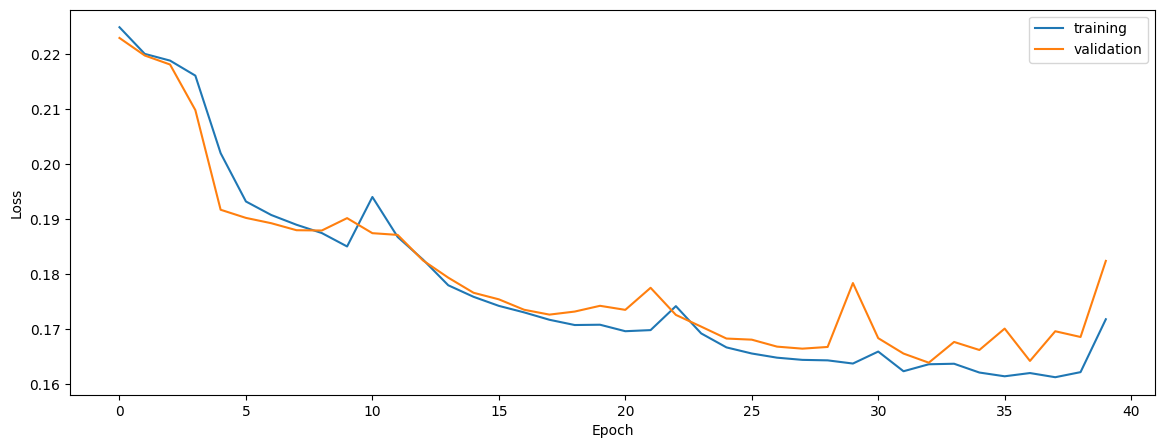

In [12]:
history = pickleLoad(path+'/{}.pkl'.format(HASH))
plotHistory(history)

In [13]:
props2 = props
model2 = model

In [14]:
def getTrue(threshold):
    props=props1.copy()
    props['threshold'] = threshold
    props['radiomics'] = []
    props['radiomics_vox'] = [{'im':'t1','fe':['k5_b25']}]
    props['balance_data'] = False
    gen = DataGenerator(**props)
    return gen

def getPred(threshold, cla, reg):
    reg = reg[:,0]
    pred = cla.copy()
    pred[:,-1] = np.where(reg < threshold, 1, 0)
    for i in range(cla.shape[-1]-1):
        pred[:,i] = np.where(reg < threshold, 0, pred[:,i])
    return pred

In [15]:
from util import getAccuarcy, predictInBatches

props1['balance_data'] = False
props2['balance_data'] = False
gen1 = DataGenerator(**props1)
gen2 = DataGenerator(**props2)
train1, val1, test1 = gen1.getData()
train2, val2, test2 = gen2.getData()

train_cla = predictInBatches(model1,train1[0],architecture['batch_size'])
val_cla = predictInBatches(model1,val1[0],architecture['batch_size'])
test_cla = predictInBatches(model1,test1[0],architecture['batch_size'])
train_reg = predictInBatches(model2,train2[0],architecture['batch_size'])
val_reg = predictInBatches(model2,val2[0],architecture['batch_size'])
test_reg = predictInBatches(model2,test2[0],architecture['batch_size'])

threshold = props['threshold']

gen = getTrue(threshold)
train_true, val_true, test_true = gen.getData()
train_pred = getPred(threshold, train_cla, train_reg)
val_pred = getPred(threshold, val_cla, val_reg)
test_pred = getPred(threshold, test_cla, test_reg)

print(getAccuarcy(train_true[1],train_pred))
print(getAccuarcy(val_true[1],val_pred))
print(getAccuarcy(test_true[1],test_pred))

0.6268966327207791
0.6056938022754429
0.5818287104059296


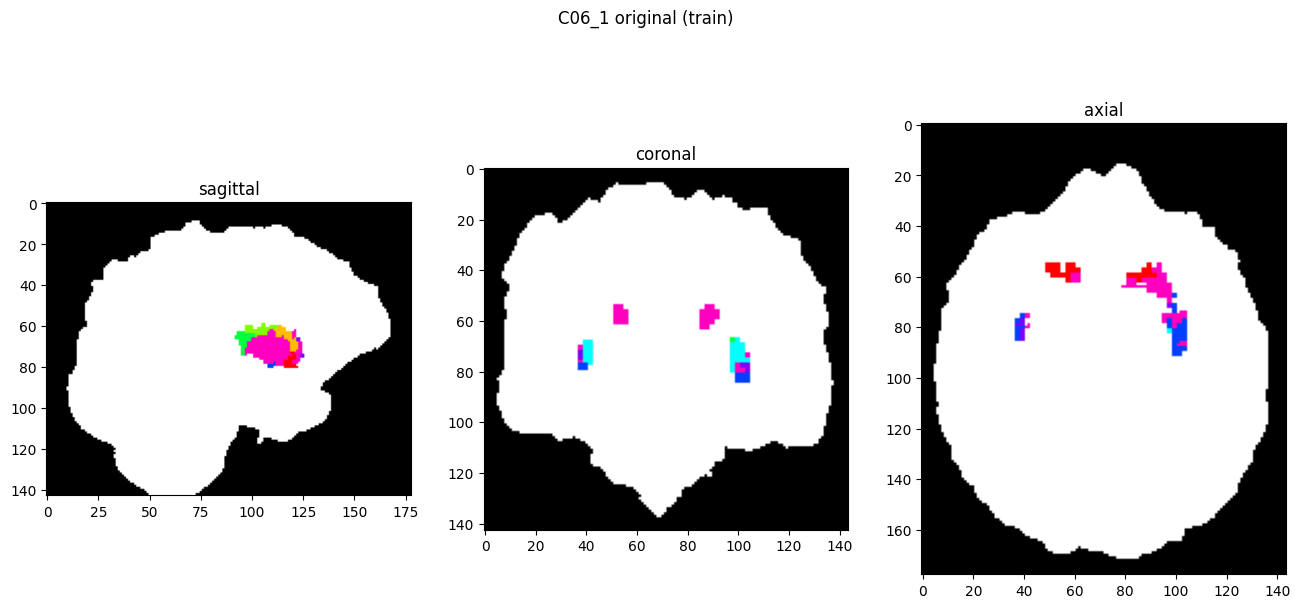

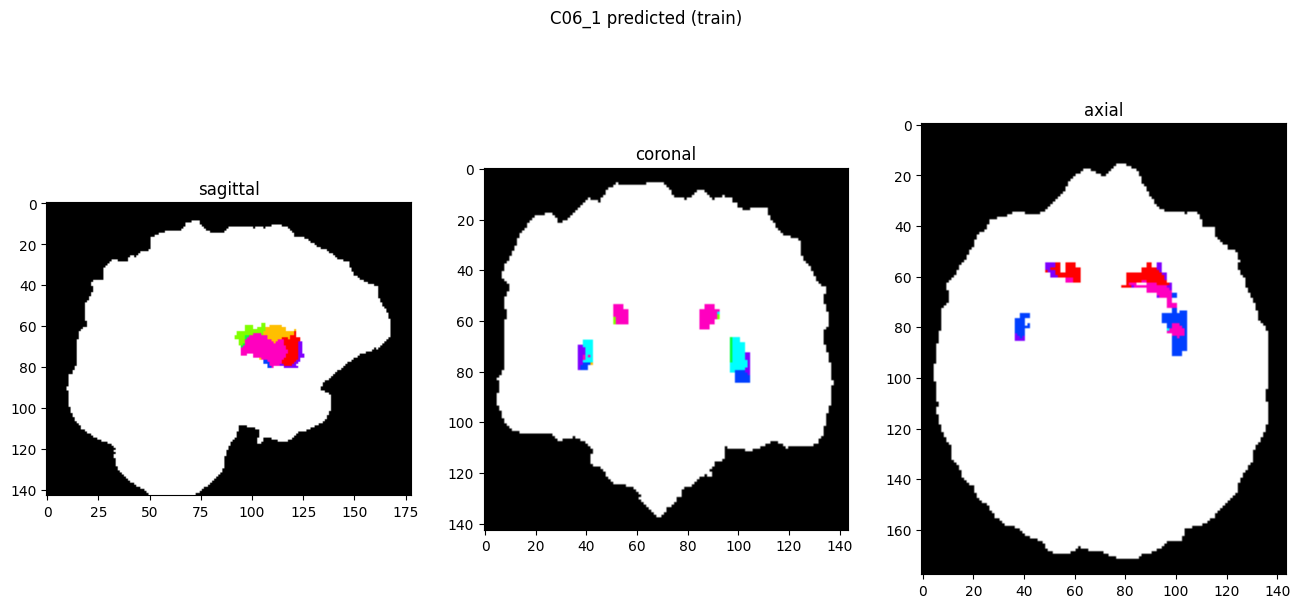

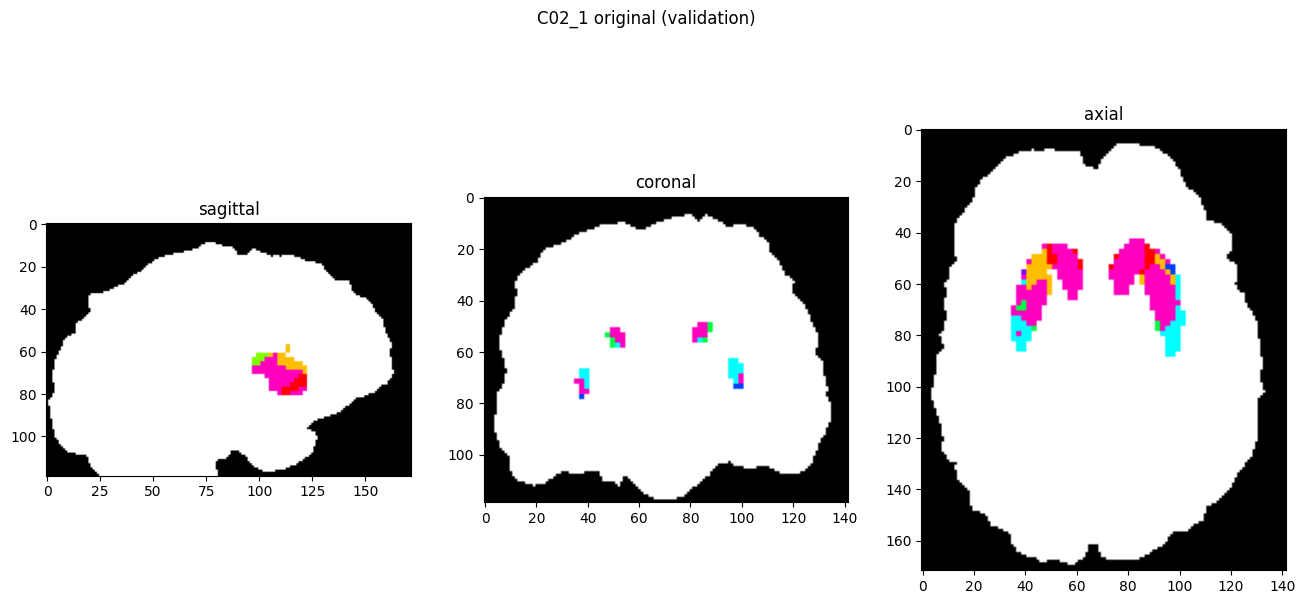

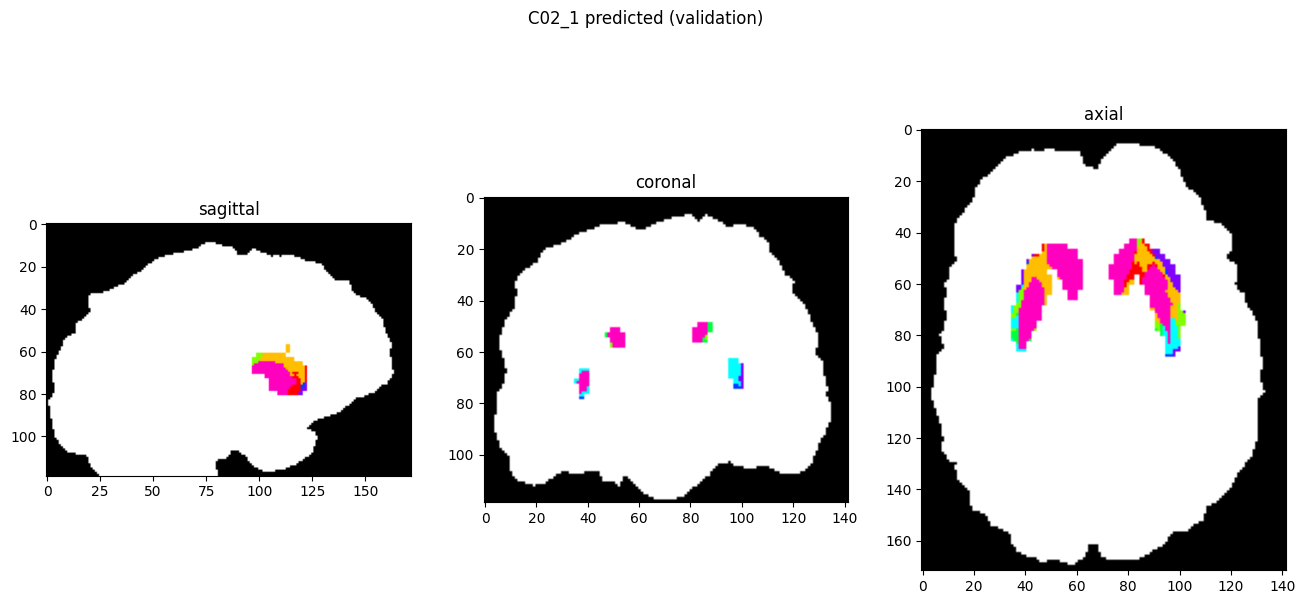

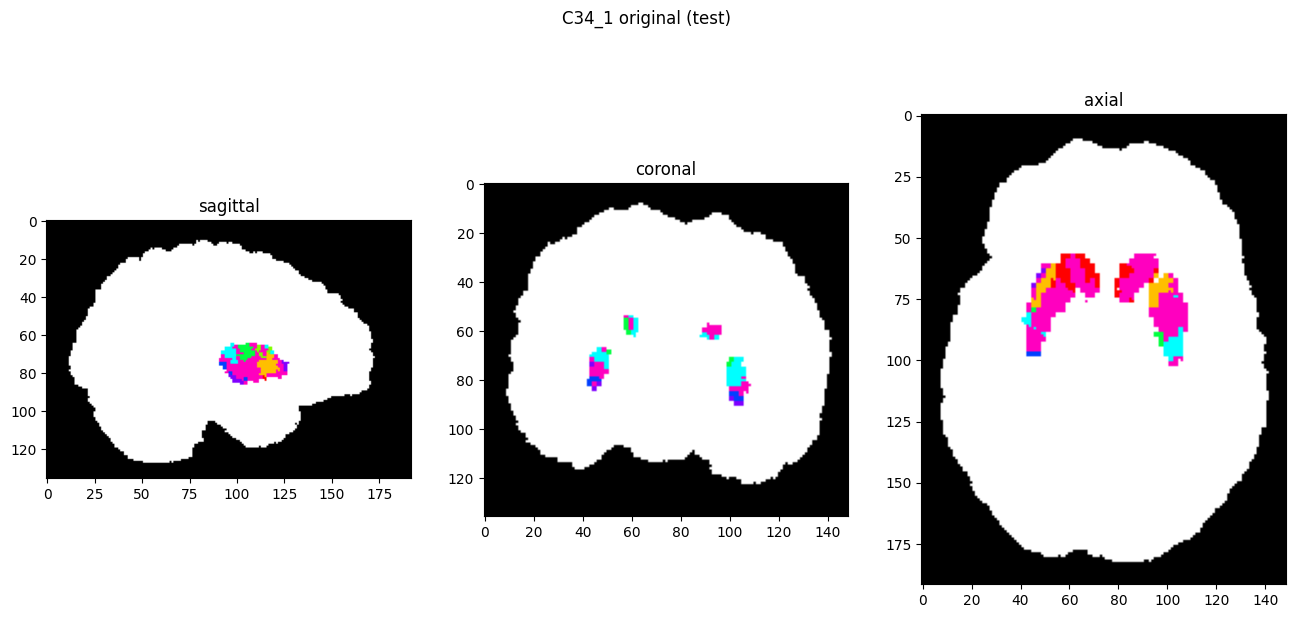

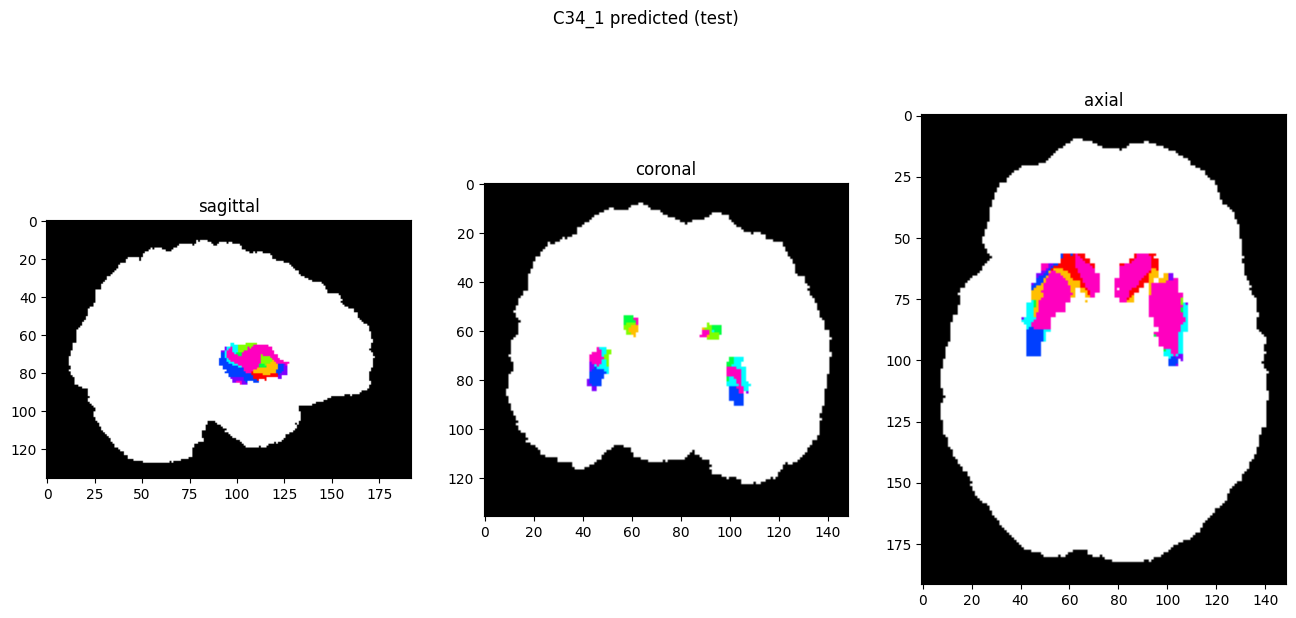

In [16]:
def customPredict(mode):
    idx = {'train':0,'validation':1,'test':2}[mode]
    dat_cla = gen1.getReconstructor(gen1.names[idx][0])
    dat_reg = gen2.getReconstructor(gen2.names[idx][0])
    pred_cla = predictInBatches(model1,dat_cla[0],architecture['batch_size'])
    pred_reg = predictInBatches(model2,dat_reg[0],architecture['batch_size'])
    return getPred(threshold, pred_cla, pred_reg)

showResults(model, gen, threshold=0, predict=customPredict)